In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, print_params, generate_random_params
from tools.losses import compute_loss_with_time
from tools.simulation import setup_event_simulator
import time

# Define temperatures
temperatures = [0.1, 0.5, 1.0]
Nphot = 1_000_000

# Load detector configuration
default_json_filename = 'config/cyl_geom_config.json'
detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)

# Set up simulators for each temperature
simulators = {
    temp: setup_event_simulator(default_json_filename, Nphot, temp, is_data=True)
    for temp in temperatures
}

In [2]:
# Generate random true parameters
key_id = 1739779288# int(time.time())

key = jax.random.PRNGKey(key_id)
key, subkey = jax.random.split(key)
true_params = generate_random_params(subkey)

# Define parameter changes as percentages of true values
param_changes = (
    jnp.array(200.0),             # Energy in MeV
    jnp.array([1.0, 0.0, 0.0]),   # position
    jnp.array([0.75, 0.0, 0.0]),  # direction
)

print("Generated true parameters:")
print_params(true_params)

Generated true parameters:
Event Parameters:
────────────────────
Energy: 667.43 MeV
Initial Position: (0.05, 0.12, -0.53)
Initial Direction: (0.47, -1.23, 0.45)
Initial Intensity: 7.43
────────────────────


Event Parameters:
────────────────────
Energy: 667.43 MeV
Initial Position: (0.05, 0.12, -0.53)
Initial Direction: (0.47, -1.23, 0.45)
Initial Intensity: 7.43
────────────────────


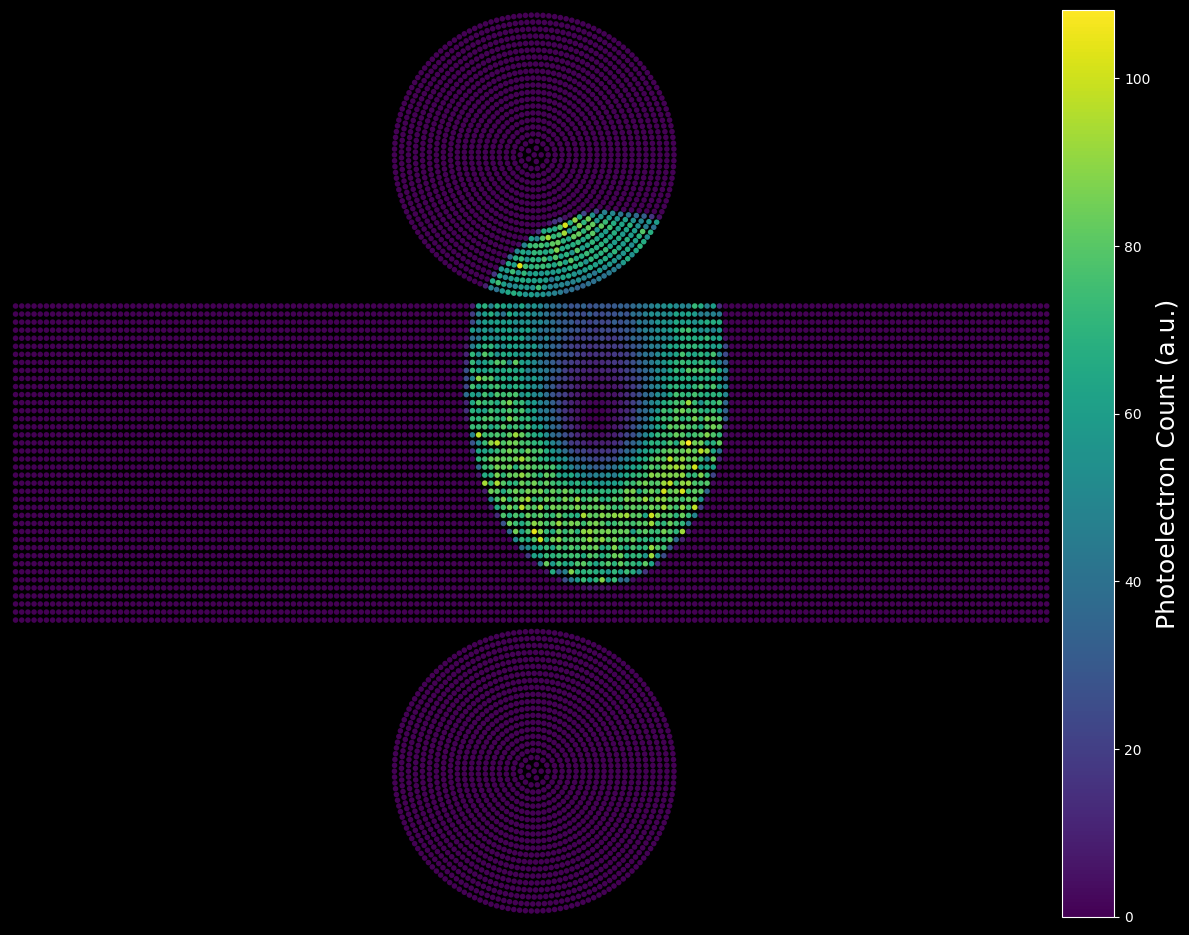

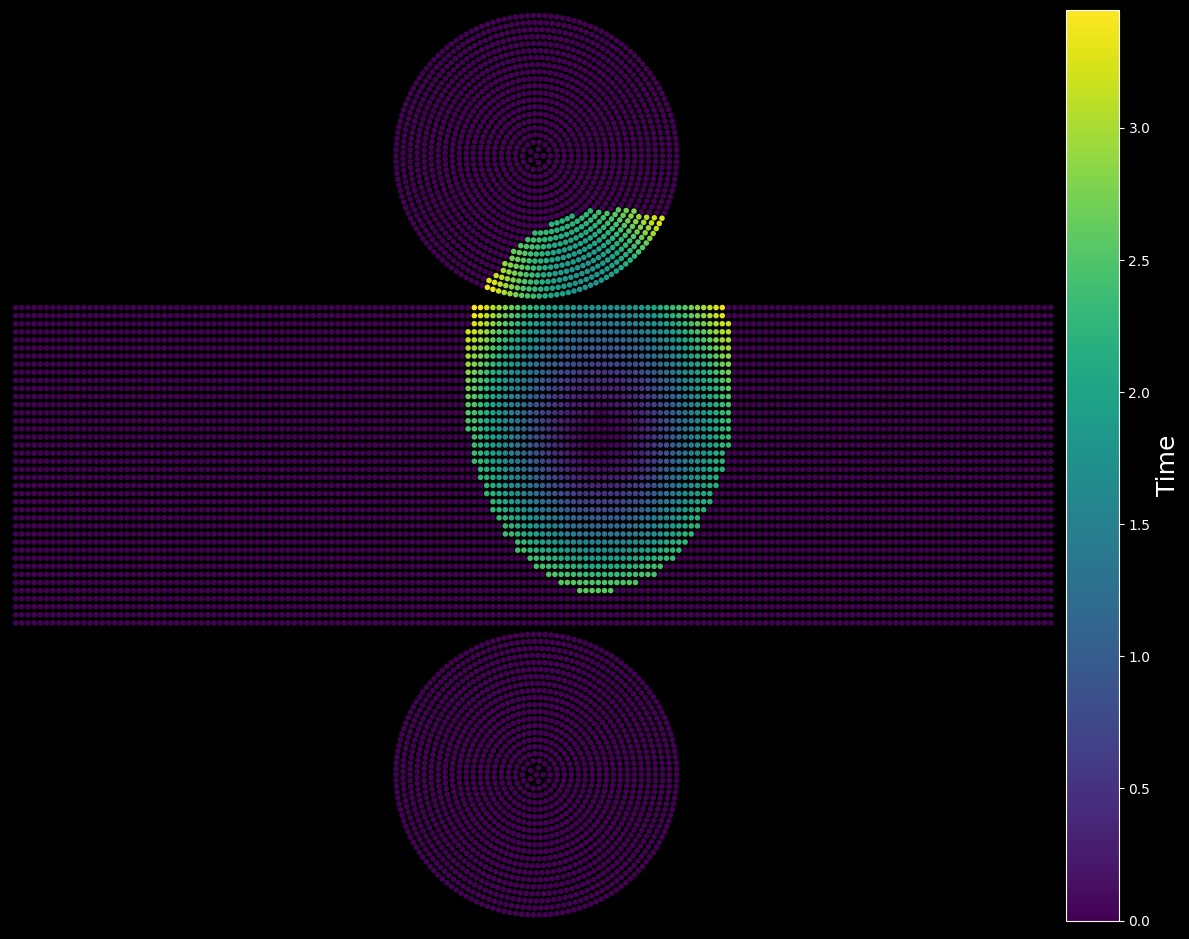

In [3]:
temperature = 0.0
Nphot = 1_000_000
simulate_true_data = setup_event_simulator(default_json_filename, Nphot, temperature, is_data=True)
Nphot = 1_000_000

# Generate true data
true_data_temp = jax.lax.stop_gradient(simulate_true_data(true_params, key))

fname = 'events/true_event_data_'+str(key_id)+'_'+str(Nphot)+'.h5'

save_single_event(true_data_temp, true_params, filename=fname)
true_data = load_single_event(fname, NUM_DETECTORS, sparse=False)[1:]

from tools.visualization import create_detector_display
loaded_params, loaded_indices, loaded_charges, loaded_times = load_single_event(fname, NUM_DETECTORS)
print_params(loaded_params)

detector_display = create_detector_display()
detector_display(loaded_indices, loaded_charges, loaded_times, file_name=
                 'event_display_Q_'+str(key_id)+'_'+str(Nphot)+'.png', plot_time=False)
detector_display(loaded_indices, loaded_charges, loaded_times, file_name=
                 'event_display_T_'+str(key_id)+'_'+str(Nphot)+'.png', plot_time=True)

In [4]:
print('Total Q: ', int(jnp.sum(true_data_temp[0])))

Total Q:  86114


### Check that we can simulate things fast

In [5]:
%%timeit

# get a random key from time
key = jax.random.PRNGKey(int(time.time()))

true_params = generate_random_params(key)

single_event_data = simulators[temperatures[0]](true_params, key)

The slowest run took 14.59 times longer than the fastest. This could mean that an intermediate result is being cached.
10.1 ms ± 7.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# Part 1: Data Generation
import numpy as jnp
from functools import partial
import pickle

def create_loss_and_grad_fn(simulator):
    @jit
    def loss_and_grad_fn(params):
        def loss_fn(p):
            simulated_data = simulator(p, key)
            return compute_loss_with_time(detector_points, *true_data, *simulated_data)
        return value_and_grad(loss_fn)(params)
    return loss_and_grad_fn

def generate_param_ranges(true_params, param_changes, num_points=201):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

def generate_plot_data(param_index, param_values, simulator):
    losses = []
    gradients = []
    
    loss_and_grad_fn = create_loss_and_grad_fn(simulator)

    for new_value in param_values:
        new_params = list(true_params)
        if param_index in [1, 2]:  # position and direction
            new_params[param_index] = new_params[param_index].at[0].set(new_value)
        else:  # opening angle and intensity
            new_params[param_index] = new_value
            
        new_params = tuple(new_params)
        loss, grad = loss_and_grad_fn(new_params)
        gradient = grad[param_index]
        if param_index in [1, 2]:
            gradient = gradient[0]

        losses.append(loss)
        gradients.append(gradient)

    return jnp.array(losses), jnp.array(gradients)

def generate_analysis_data(true_params, param_changes, temperatures, simulators, num_points=201):
    """Generate and save all analysis data."""
    # Generate parameter ranges
    param_ranges = generate_param_ranges(true_params, param_changes, num_points)
    param_names = ['Energy', 'Position X', 'Direction X']
    
    # Store all data in a dictionary
    analysis_data = {
        'param_ranges': param_ranges,
        'param_names': param_names,
        'true_params': true_params,
        'temperatures': temperatures,
        'results': {}
    }
    
    # Generate data for each parameter and temperature
    for param_idx, param_name in enumerate(param_names):
        param_values = param_ranges[param_idx]
        analysis_data['results'][param_name] = {}
        
        for temp in temperatures:
            losses, gradients = generate_plot_data(param_idx, param_values, simulators[temp])
            analysis_data['results'][param_name][temp] = {
                'losses': losses,
                'gradients': gradients
            }
    
    return analysis_data

def save_analysis_data(analysis_data, filename='analysis_data.pkl'):
    """Save the analysis data to a file."""
    with open(filename, 'wb') as f:
        pickle.dump(analysis_data, f)

def load_analysis_data(filename='analysis_data.pkl'):
    """Load the analysis data from a file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [7]:
analysis_data = generate_analysis_data(true_params, param_changes, temperatures, simulators)
save_analysis_data(analysis_data)
print('Ready to Plot')

Ready to Plot


In [8]:
from matplotlib import colors

def get_color_hex(color_name_or_hex):
    # If it's already a hex color starting with #, return it as is
    if isinstance(color_name_or_hex, str) and color_name_or_hex.startswith('#'):
        return color_name_or_hex
    
    # Convert named color to hex
    try:
        return colors.to_hex(color_name_or_hex)
    except ValueError:
        raise ValueError(f"Invalid color name: {color_name_or_hex}")

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

def get_middle_color(color1, color2):
    # Convert both colors to hex first
    hex1 = get_color_hex(color1)
    hex2 = get_color_hex(color2)
    
    # Convert hex colors to RGB
    rgb1 = hex_to_rgb(hex1)
    rgb2 = hex_to_rgb(hex2)
    
    # Calculate the middle value for each component
    middle_rgb = tuple(int((c1 + c2) / 2) for c1, c2 in zip(rgb1, rgb2))
    
    return rgb_to_hex(middle_rgb)

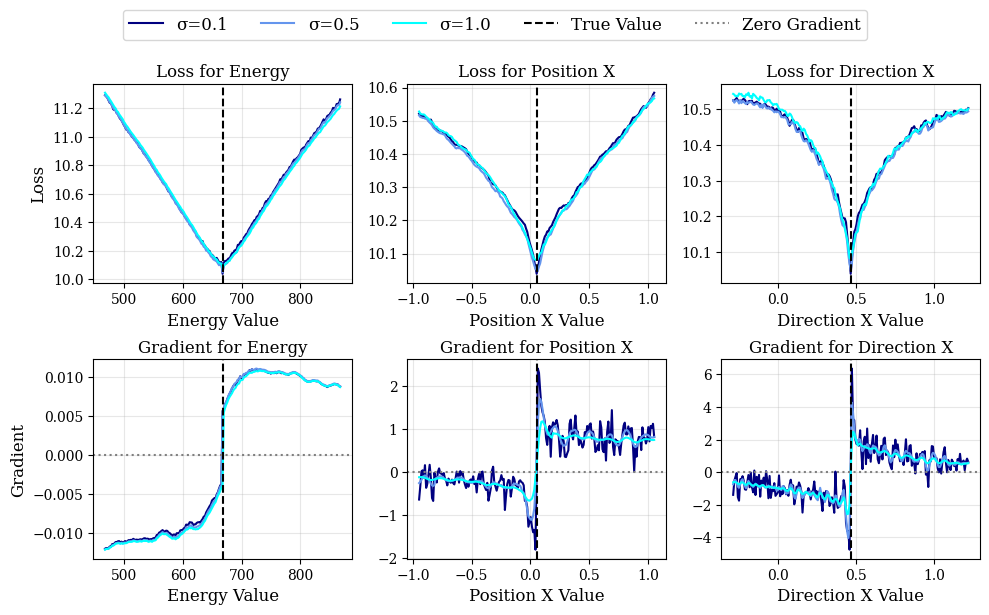

In [9]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

def plot_analysis_results(analysis_data):
    """
    Plot the analysis results with a common legend for all subplots.
    
    Args:
        analysis_data: Dictionary containing all the analysis data
    """
    param_names = analysis_data['param_names']
    temperatures = analysis_data['temperatures']
    true_params = analysis_data['true_params']
    
    
    colors = ['navy', 'cornflowerblue' , 'cyan']
    
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    
    # Lists to store legend handles and labels
    all_lines = []
    all_labels = []
        
    # First row for losses, second row for gradients
    for param_idx, param_name in enumerate(param_names):
        param_values = analysis_data['param_ranges'][param_idx]
        true_value = true_params[param_idx] if param_idx not in [1, 2] else true_params[param_idx][0]
        
        ax_loss = axs[0, param_idx]
        ax_grad = axs[1, param_idx]
        
        for temp_idx, temp in enumerate(temperatures):
            results = analysis_data['results'][param_name][temp]
            losses = results['losses']
            gradients = results['gradients']
            
            label = f'σ={temp}'
            color = colors[temp_idx]
            
            # Plot loss and gradient
            line_loss = ax_loss.plot(param_values, losses, color=color, lw=1.5)[0]
            line_grad = ax_grad.plot(param_values, gradients, color=color, lw=1.5)[0]
            
            # Only store temperature-related legend items from the first parameter
            if param_idx == 0:
                all_lines.append(line_loss)
                all_labels.append(label)

        # Add reference lines
        true_line = ax_loss.axvline(x=true_value, color='black', linestyle='--')
        ax_grad.axvline(x=true_value, color='black', linestyle='--')
        
        zero_line = ax_grad.axhline(y=0, color='gray', linestyle=':')
        
        # Only store reference lines from the first parameter
        if param_idx == 0:
            all_lines.extend([true_line, zero_line])
            all_labels.extend(['True Value', 'Zero Gradient'])

        # Configure axes without individual legends
        ax_loss.set_title(f'Loss for {param_name}', pad=5, fontsize=12)
        ax_loss.set_xlabel(f'{param_name} Value', fontsize=12)
        if param_idx == 0:
            ax_loss.set_ylabel('Loss', fontsize=12)
        ax_loss.grid(True, alpha=0.3)
        
        ax_grad.set_title(f'Gradient for {param_name}', pad=5, fontsize=12)
        ax_grad.set_xlabel(f'{param_name} Value', fontsize=12)
        if param_idx == 0:
            ax_grad.set_ylabel('Gradient', fontsize=12)
        ax_grad.grid(True, alpha=0.3)

    #plt.suptitle('Loss and Gradient Analysis for Different Temperatures', fontsize=16)
    
    # Adjust layout to make room for the legend
    plt.tight_layout()
    
    # Add common legend below all subplots
    fig.legend(all_lines, all_labels,
              loc='center',
              bbox_to_anchor=(0.5, 1.04),
              ncol=len(all_lines),
              fontsize=12,
              bbox_transform=fig.transFigure)
    
    # Adjust the bottom margin to make room for the legend
    plt.subplots_adjust(bottom=0.15)
    
    return fig, axs

# Usage
analysis_data = load_analysis_data()
fig, axs = plot_analysis_results(analysis_data)

plt.savefig('1D_loss_and_grads_'+str(key_id)+'_'+str(Nphot)+'.pdf', bbox_inches='tight')
plt.show()
